In [45]:
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
import optuna
import shap

import csv
import pandas as pd
import numpy as np

import pydotplus
from six import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [5]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'../data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'../data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

### Hyperparameter tuning

In [15]:
class ModelOptimizaton:

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def objective(self, trial):
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
        n_estimators = trial.suggest_int('n_estimators', 5, 100)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        regressor = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)
        regressor.fit(self.x_train, self.y_train)
        return regressor.score(self.x_test, self.y_test)

if __name__=='__main__':
    nodes, _, _ = graph_r(rosettes[0])
    x = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
    y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    model = ModelOptimizaton(x_train, x_test, y_train, y_test)
    study = optuna.create_study(direction='maximize')
    study.optimize(model.objective, n_trials=100)

[I 2024-01-03 00:50:41,945] A new study created in memory with name: no-name-26ffada2-d944-4110-ae85-98a0cdb007a1
[I 2024-01-03 00:50:42,358] Trial 0 finished with value: 0.9012973690833133 and parameters: {'criterion': 'poisson', 'n_estimators': 25, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.9012973690833133.
[I 2024-01-03 00:50:54,599] Trial 1 finished with value: 0.9031840662065311 and parameters: {'criterion': 'absolute_error', 'n_estimators': 88, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 1 with value: 0.9031840662065311.
[I 2024-01-03 00:50:54,779] Trial 2 finished with value: 0.8742665571026698 and parameters: {'criterion': 'squared_error', 'n_estimators': 17, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 1 with value: 0.9031840662065311.
[I 2024-01-03 00:50:55,395] Trial 3 finished with value: 0.8394568839365635 and parameters: {'criterion': 'poisson', 'n_estimators': 71, 'max_depth': 4, 'min_samples_split': 8}. Best is trial 1 

In [27]:
study.best_params

{'criterion': 'squared_error',
 'n_estimators': 93,
 'max_depth': 10,
 'min_samples_split': 4}

In [23]:
study.best_value

0.9038646469117999

In [49]:
param = study.best_params
regressor = RandomForestRegressor(criterion=param['criterion'], n_estimators=param['n_estimators'], max_depth=param['max_depth'], min_samples_split=param['min_samples_split'], random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

r2, mse, pc = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 0.9038646469117999
mse: 0.03572911783389321
Pearson correlation: 0.9507654010048082


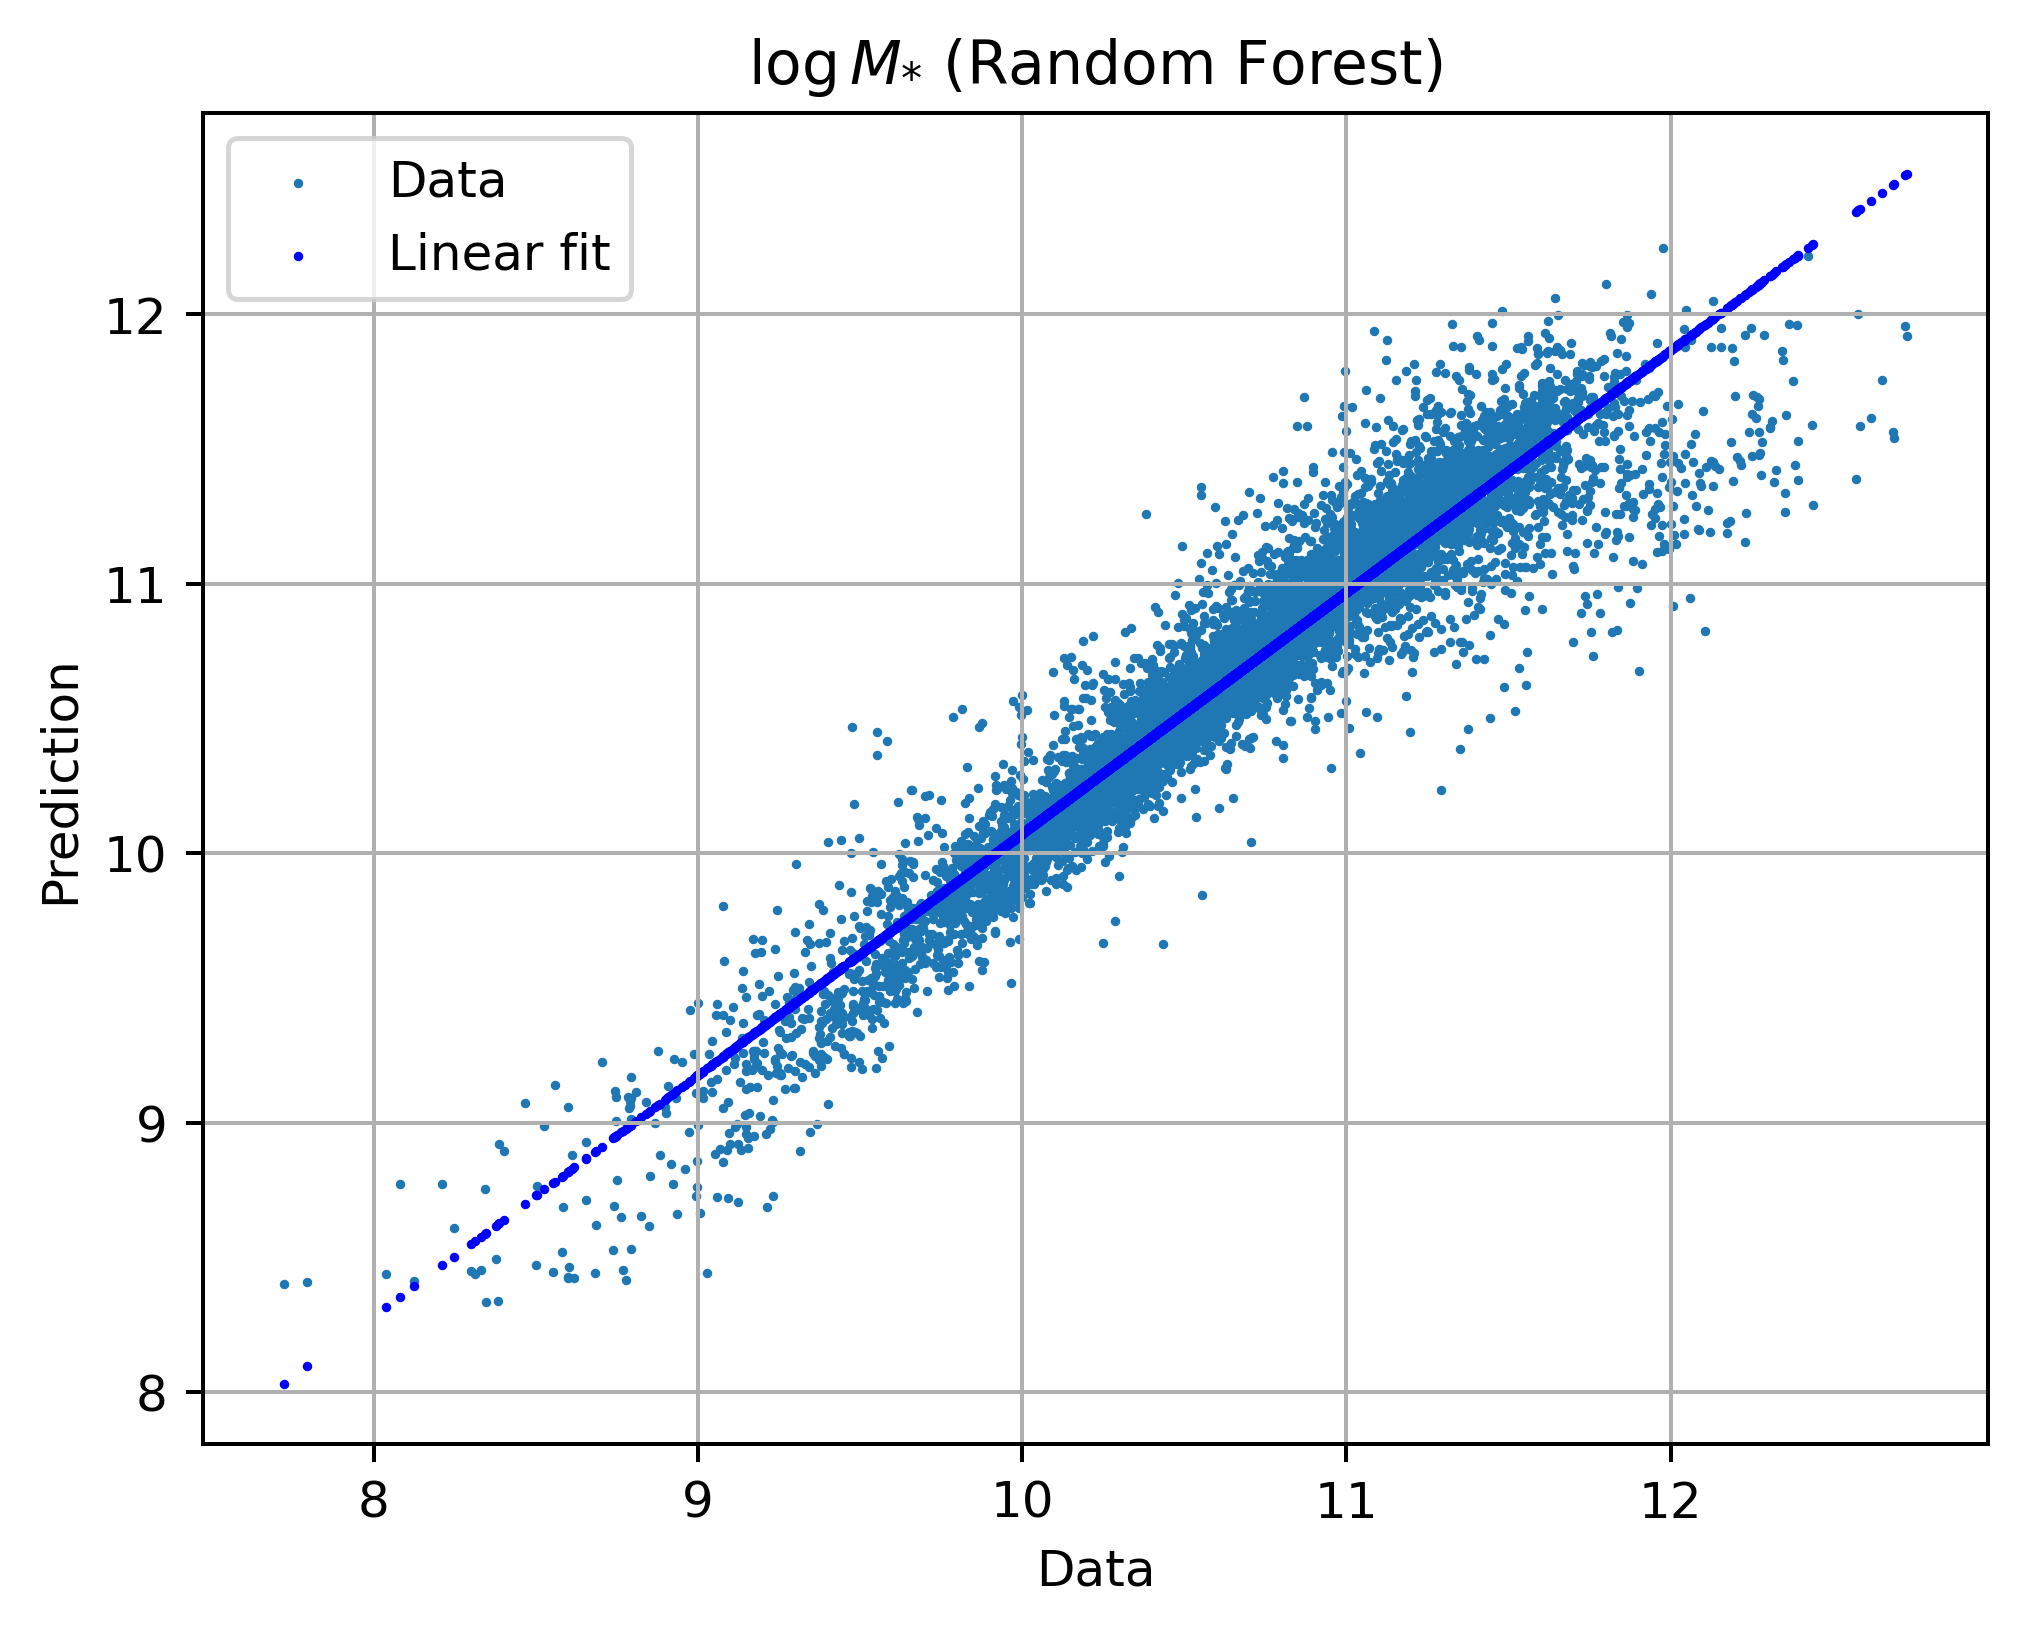

In [50]:
slope, intercept = np.polyfit(y_test, y_pred, 1)
r = slope*y_test+intercept

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=0.8)
ax.scatter(y_test, r, color='b', s=0.8)
ax.set_ylabel('Prediction')
ax.set_xlabel('Data')
plt.title(r'$\log M_{*}$ (Random Forest)')
plt.legend(['Data', 'Linear fit'])
plt.grid()
plt.show()

Graphviz tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.282464 to fit



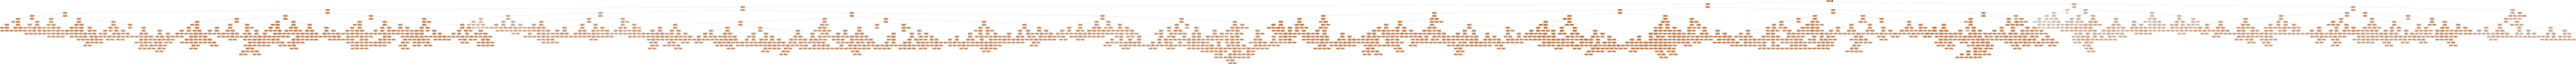

In [5]:
tree = regressor.estimators_[0]

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Feature importances

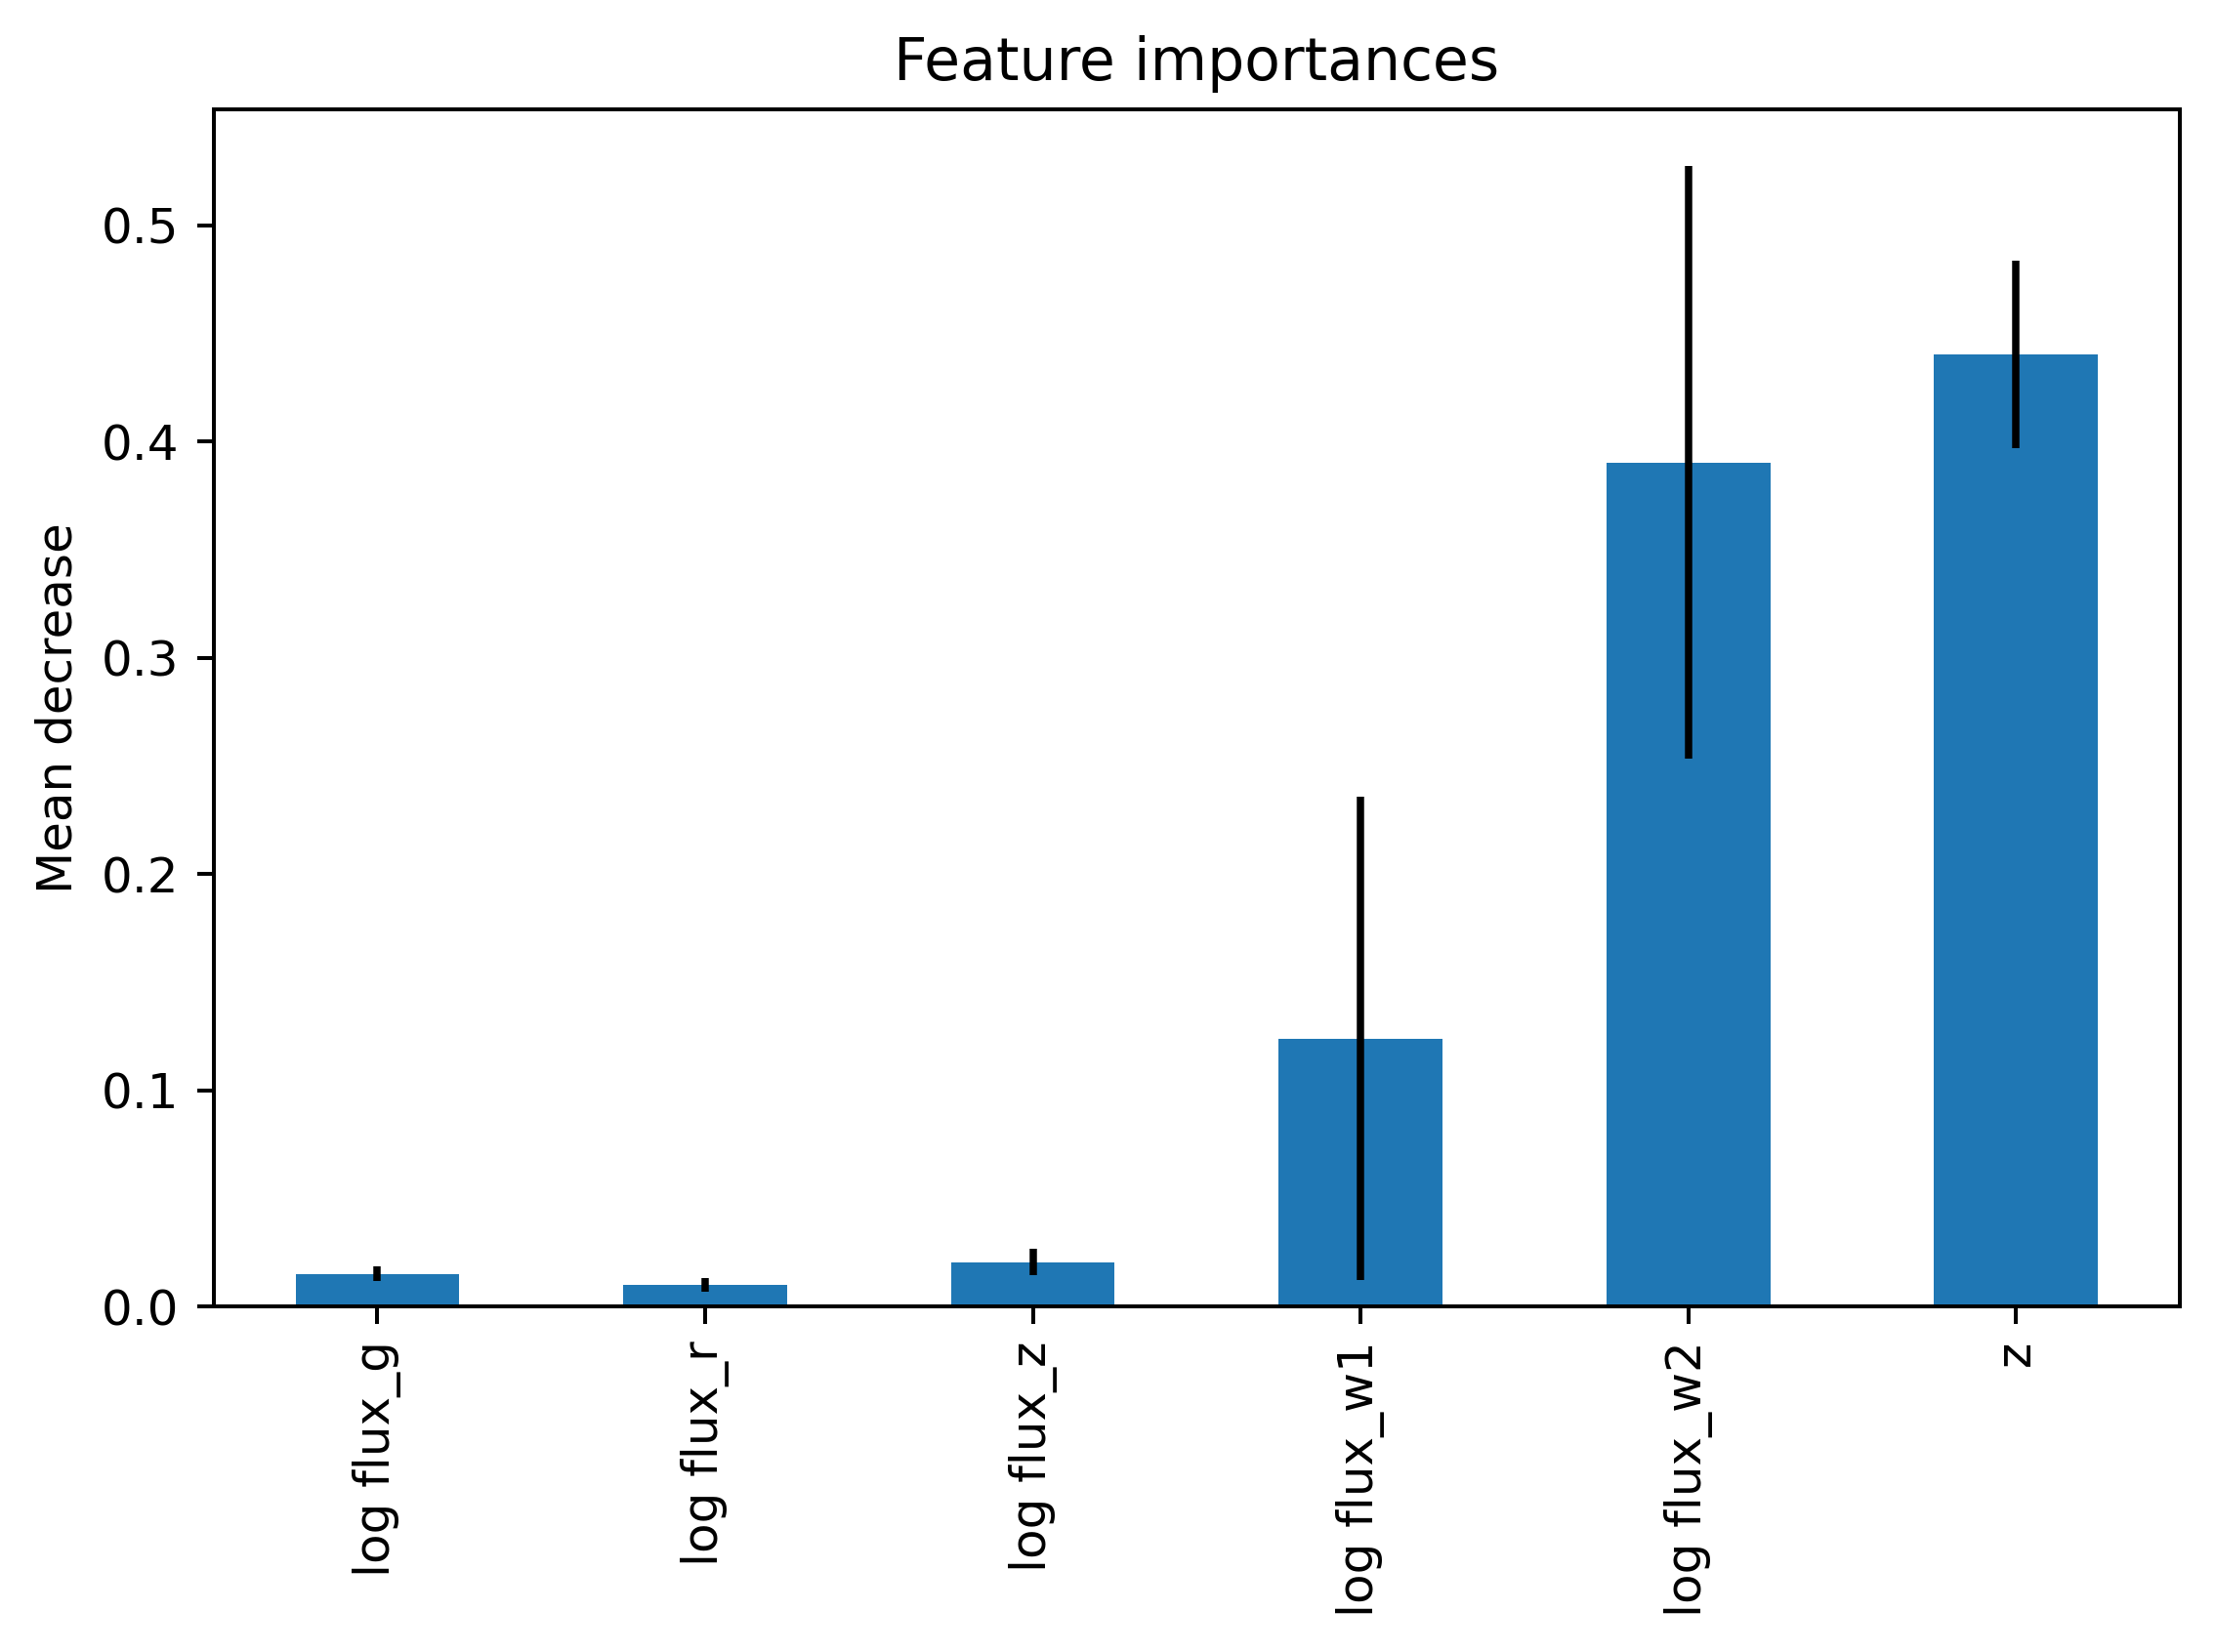

In [36]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
feature_names = [f"{i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Shap values

In [61]:
explainer = shap.Explainer(regressor.predict, x_test)
# Calculates the SHAP values - It takes some time
#shap_values = explainer(np.array(x_test))
explainer

---

Adding a random column

In [42]:
regressor_rdm = RandomForestRegressor(criterion=param['criterion'], n_estimators=param['n_estimators'], max_depth=param['max_depth'], min_samples_split=param['min_samples_split'], random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((x_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

x_test_extended = np.column_stack((x_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(x_test_extended)

r2, mse, pc = r2_score(y_test, y_pred_extended), mean_squared_error(y_test, y_pred_extended), pearsonr(y_test, y_pred_extended).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 0.9036326377460734
mse: 0.035815345039125215
Pearson correlation: 0.9506554829739735


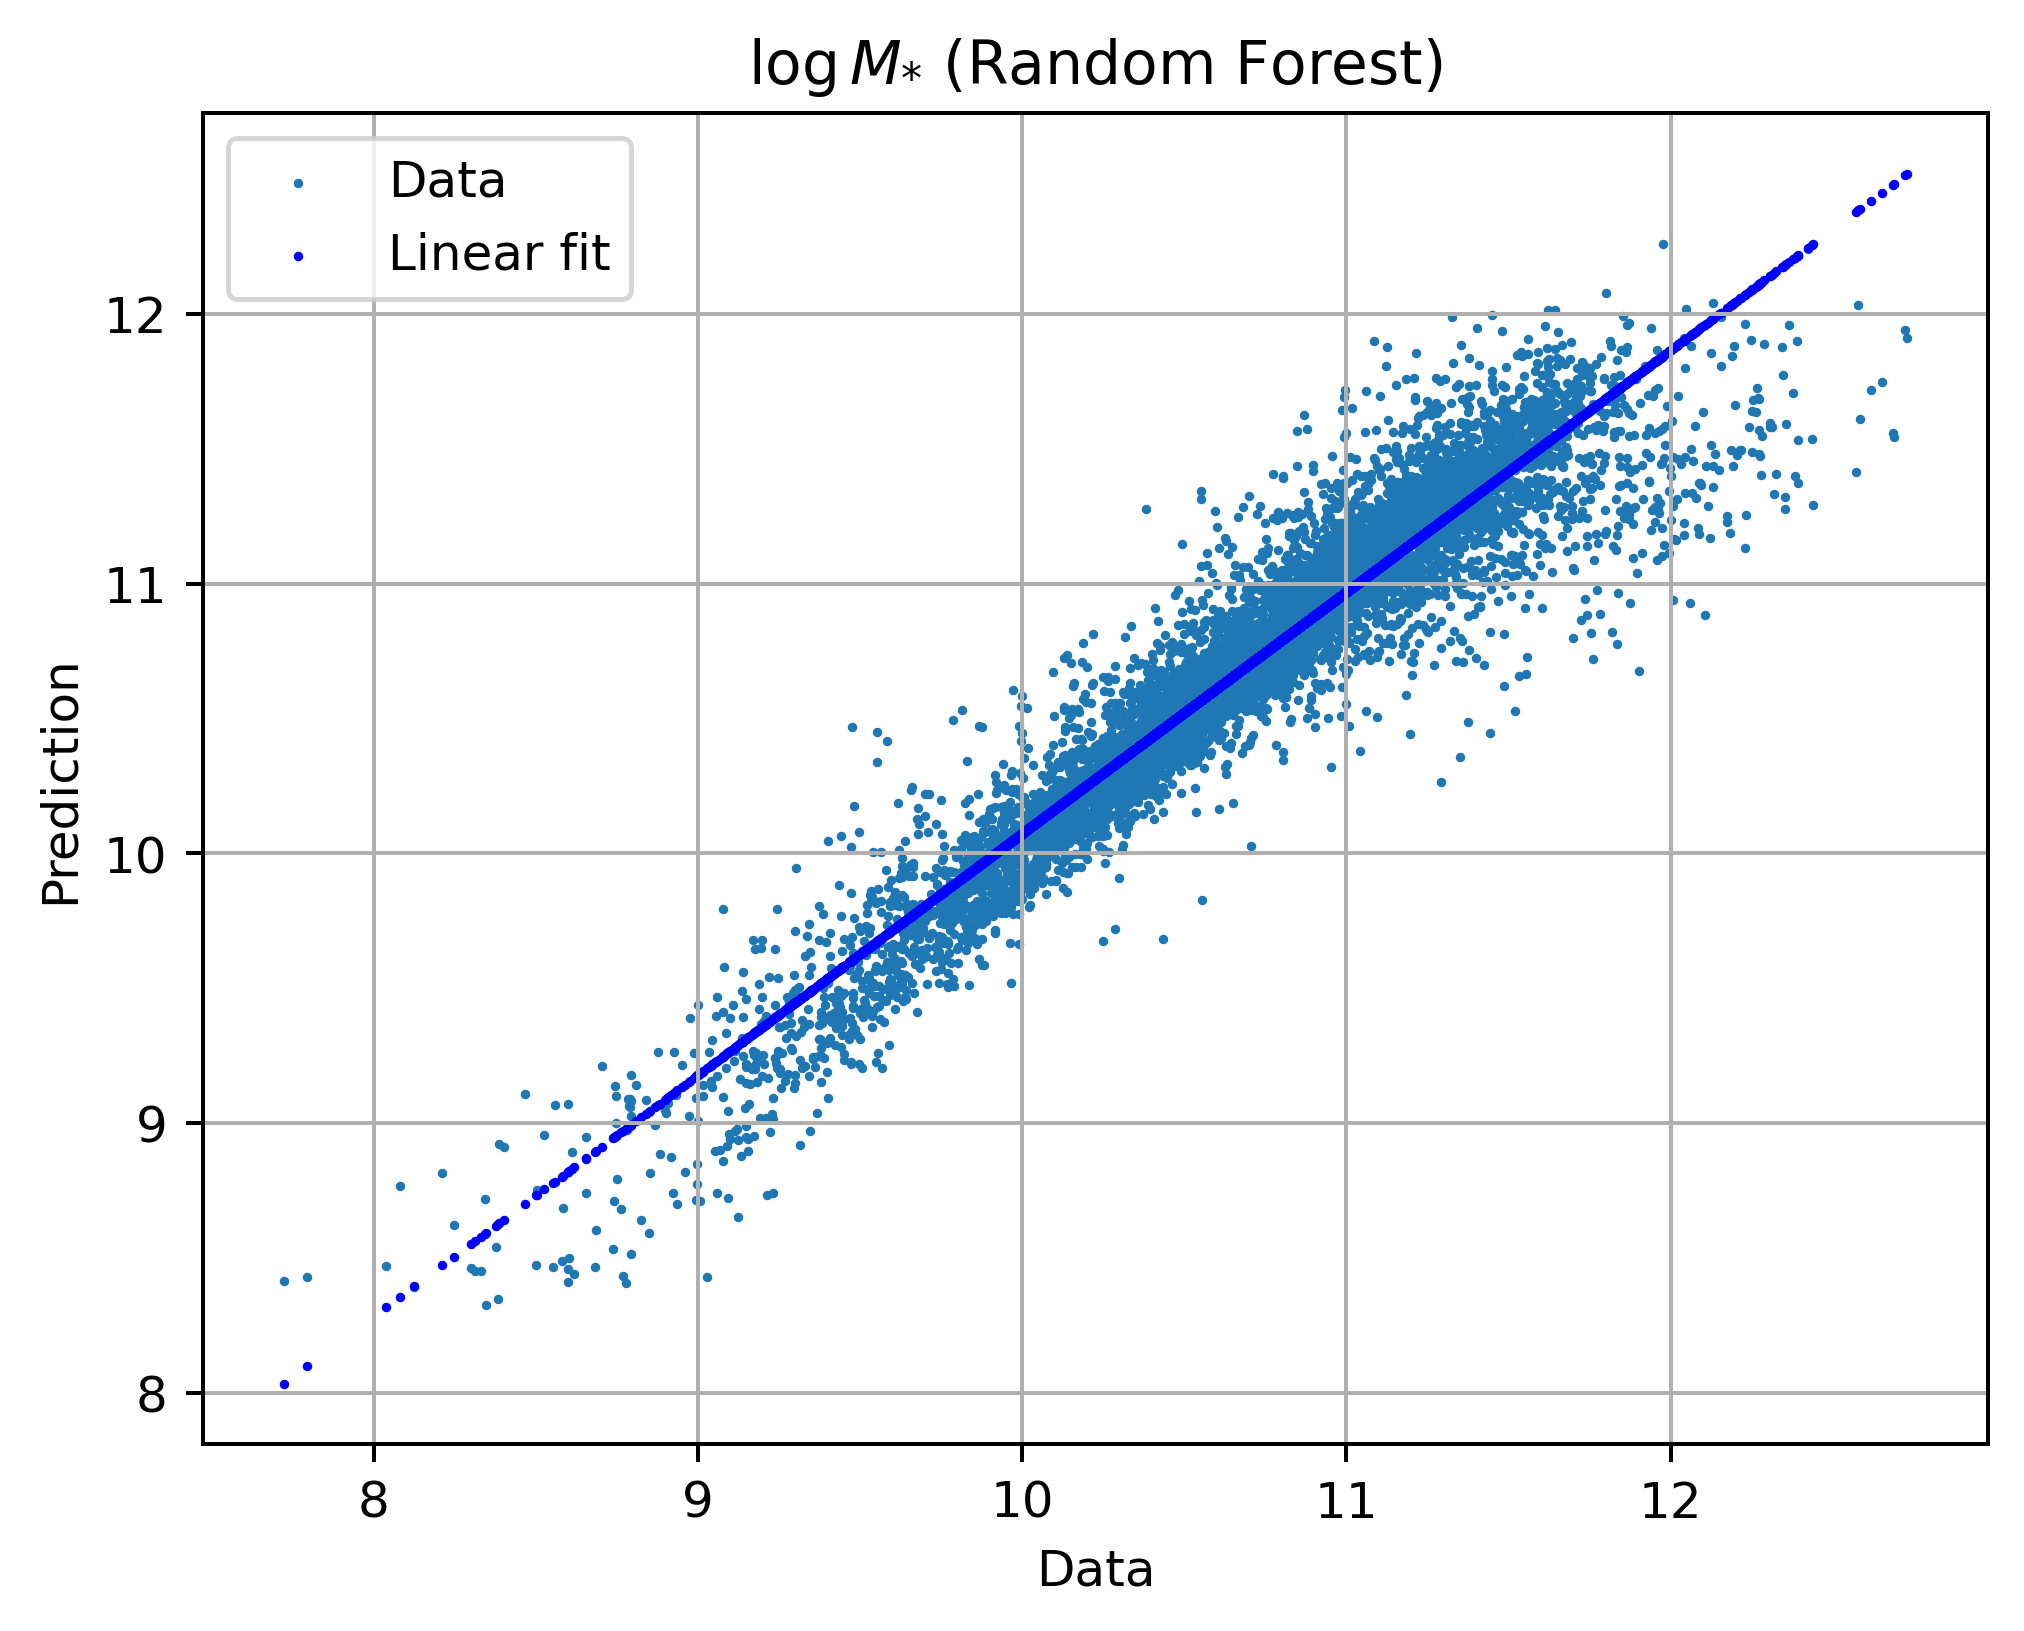

In [43]:
slope, intercept = np.polyfit(y_test, y_pred_extended, 1)
r = slope*y_test+intercept

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_extended, s=0.8)
ax.scatter(y_test, r, color='b', s=0.8)
ax.set_ylabel('Prediction')
ax.set_xlabel('Data')
plt.title(r'$\log M_{*}$ (Random Forest)')
plt.legend(['Data', 'Linear fit'])
plt.grid()
plt.show()

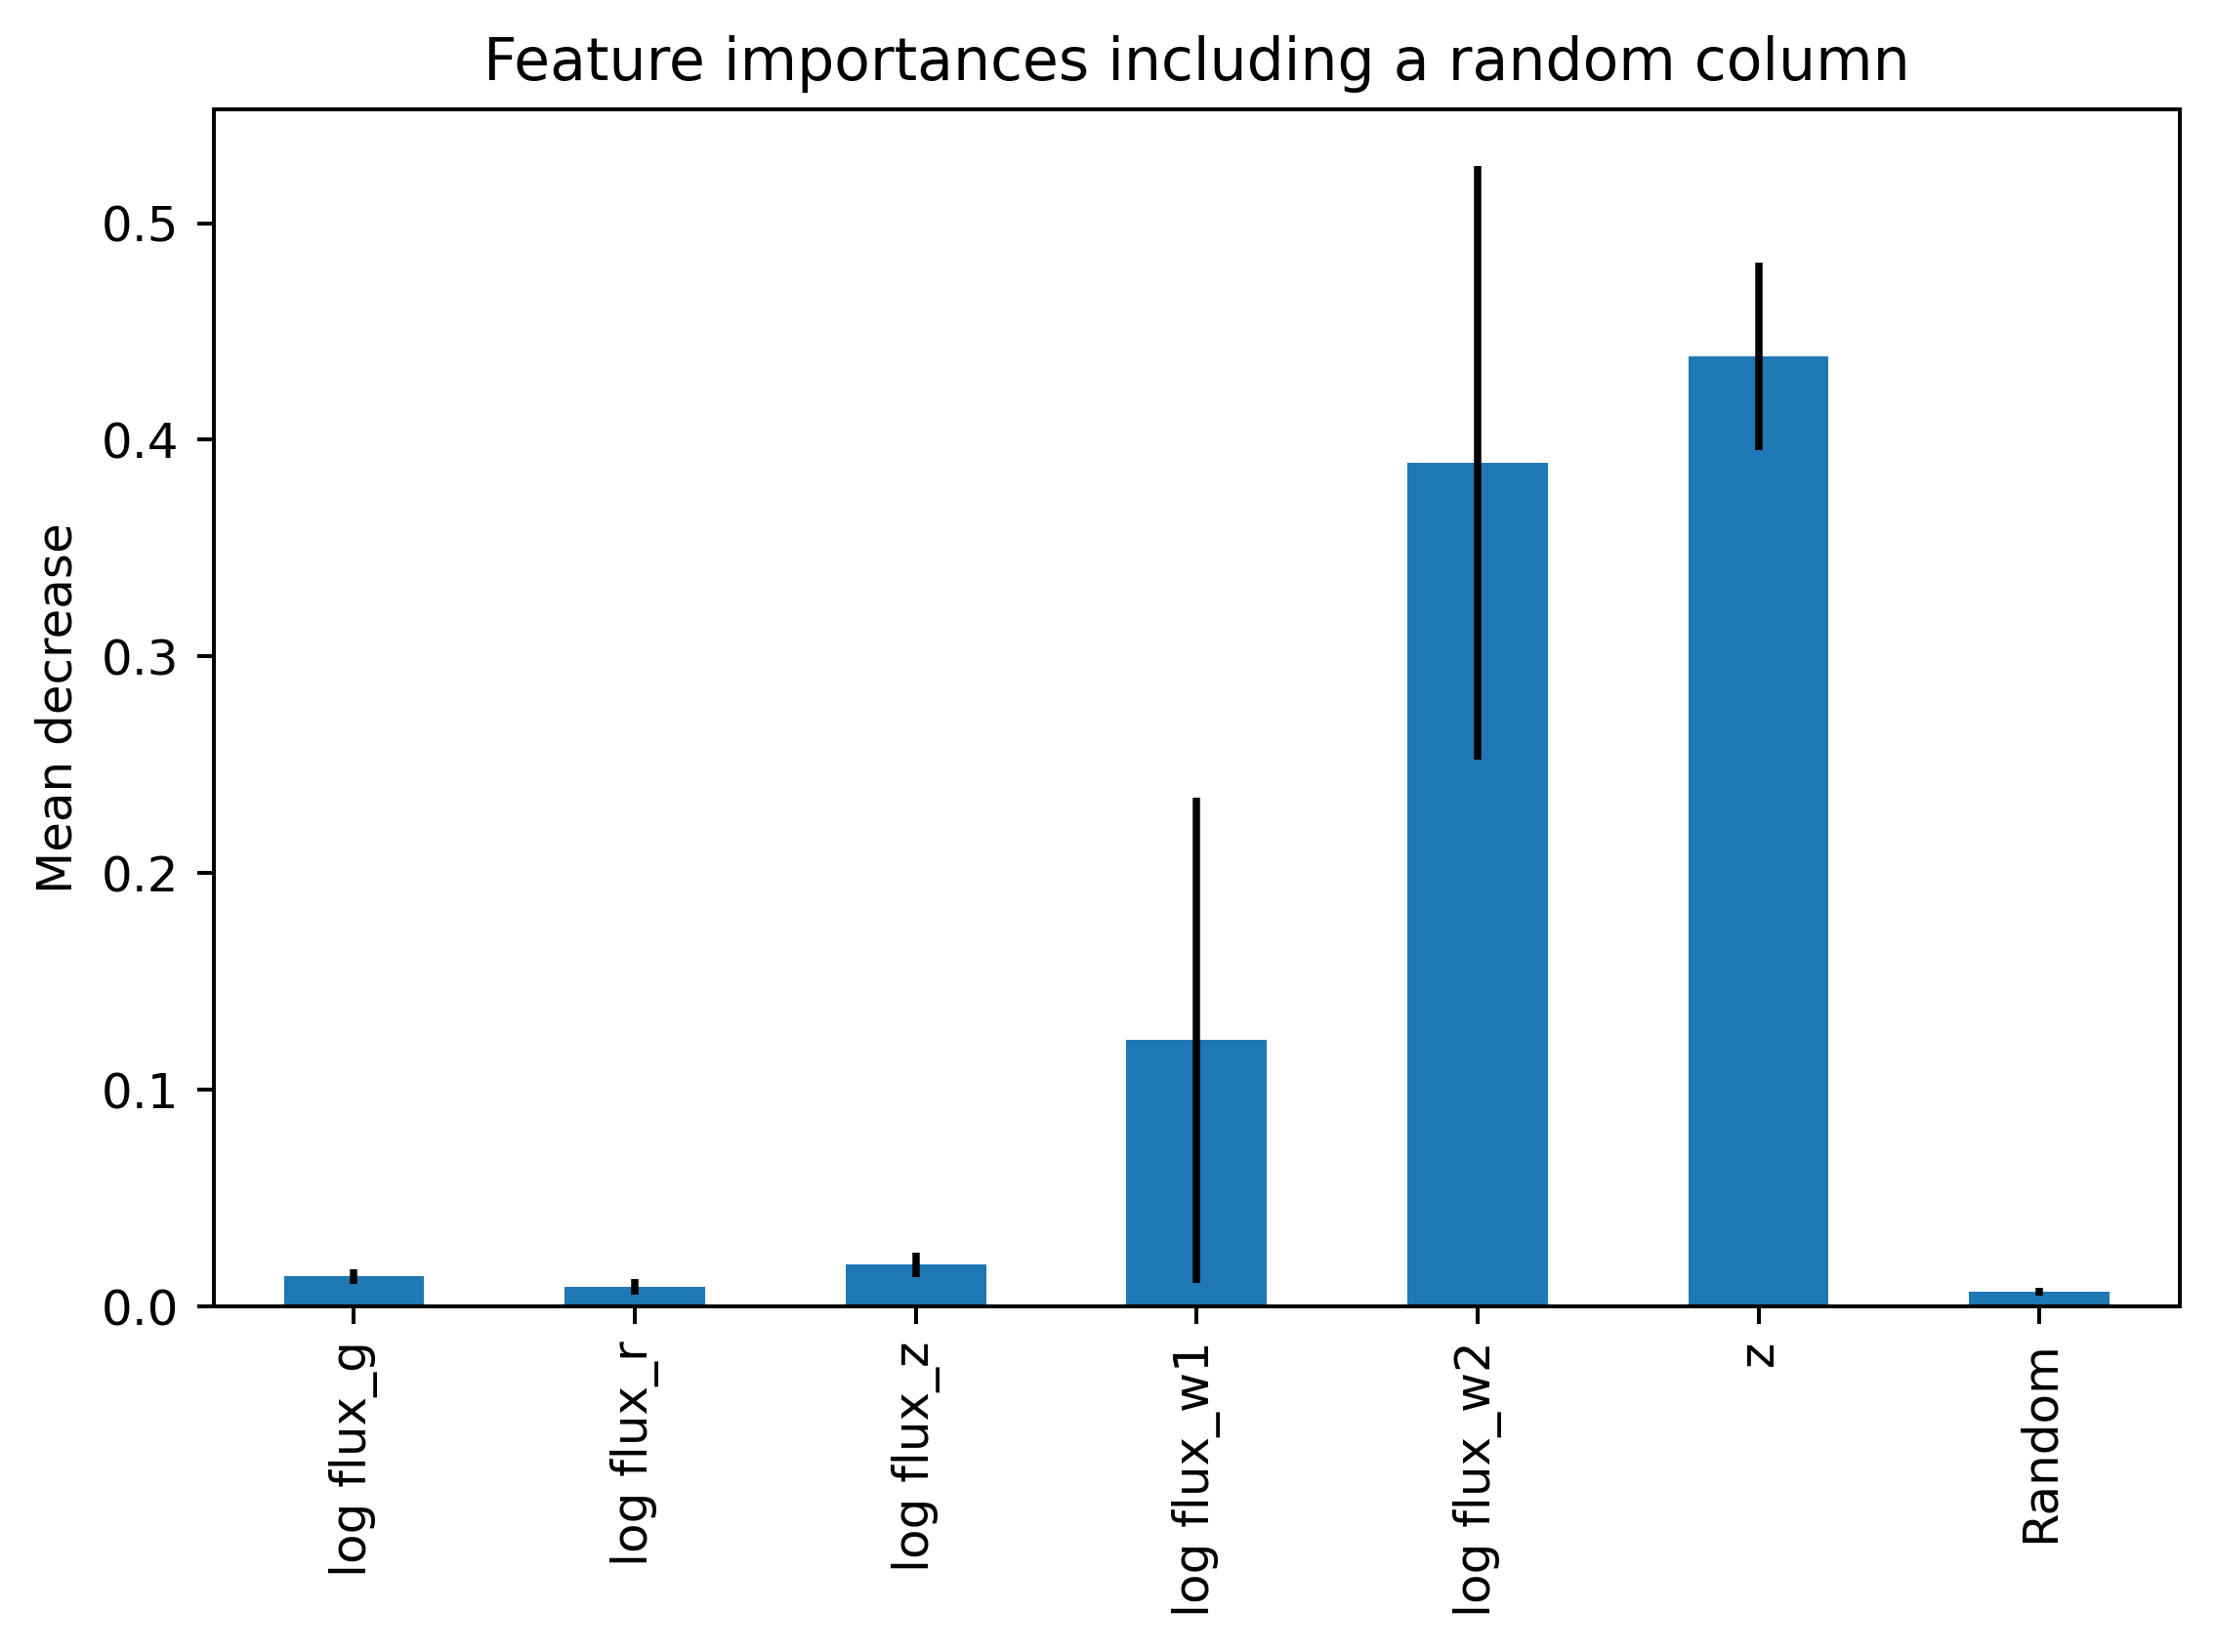

In [39]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z', 'Random']
feature_names = [f"{i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances including a random column")
ax.set_ylabel("Mean decrease")
fig.tight_layout()